In [2]:
!pip install tensorflow-metal
!pip install tensorflow-macos

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [6]:
import tensorflow as tf
import keras.layers
from keras import layers,models
from keras.layers import Dense, Dropout
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
import keras

In [7]:
pretrained_model = keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

2024-09-09 12:56:47.284694: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-09-09 12:56:47.284713: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-09-09 12:56:47.284736: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-09-09 12:56:47.284753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-09 12:56:47.284770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
image_size = (224, 224)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "./InsectImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4395 files belonging to 12 classes.
Using 3516 files for training.
Using 879 files for validation.


In [9]:
checkpoint_path = "insect_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)


In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
])


inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(12, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        #steps_per_epoch=100,
        validation_data=val_ds,
        #validation_steps=50,
        epochs=100,
        callbacks=[
            create_tensorboard_callback("training_logs", 
                                        "insect_classification"),
            checkpoint_callback,
        ],
        verbose=1
    )


Saving TensorBoard log files to: training_logs/insect_classification/20240909-125648
Epoch 1/100


2024-09-09 12:56:49.180991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 393ms/step - accuracy: 0.1071 - loss: 2.7270 - val_accuracy: 0.1581 - val_loss: 2.5045
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step - accuracy: 0.1514 - loss: 2.5736 - val_accuracy: 0.2184 - val_loss: 2.3477
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.1844 - loss: 2.4149 - val_accuracy: 0.2969 - val_loss: 2.2059
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.2282 - loss: 2.2780 - val_accuracy: 0.3823 - val_loss: 2.0766
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.2902 - loss: 2.1531 - val_accuracy: 0.4642 - val_loss: 1.9591
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - accuracy: 0.3365 - loss: 2.0607 - val_accuracy: 0.5176 - val_loss: 1.8500
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.4024 - loss: 1.9307 - val_accuracy: 0.5529 - val_loss: 1.7490
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.4515 - loss: 1.8258 - val_accuracy: 0.593

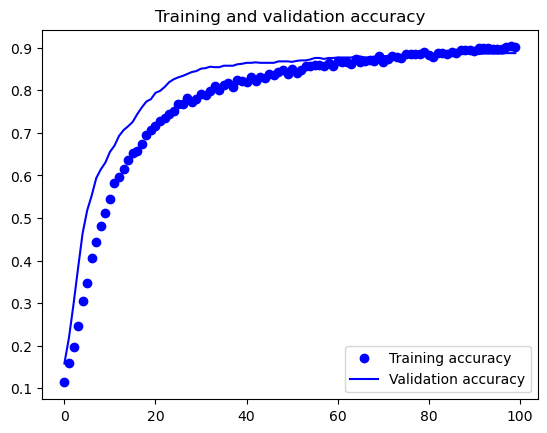

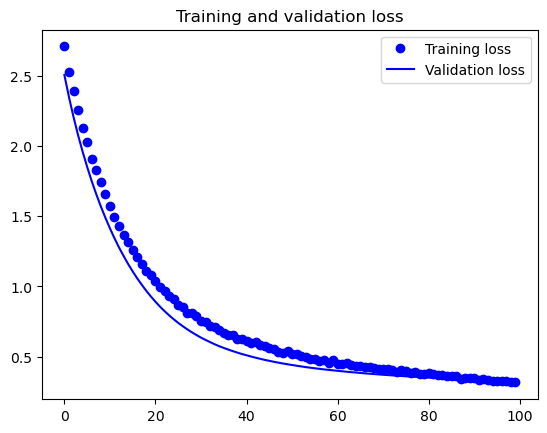

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
model.save("./models/insect.mobilenetv3large.keras")
reconstructed_model = keras.models.load_model("./models/insect.mobilenetv3large.keras")